# SIM Pattern Generator

### The Python version

From the [SI of the paper](http://www.pnas.org/content/suppl/2012/03/15/1119262109.DCSupplemental/pnas.201119262SI.pdf):



In [8]:
%pylab inline
#nice plotting
#import seaborn as sns
import numexpr as ne
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image
import os
import zipfile

from scipy.ndimage import gaussian_filter

from skimage.draw import circle

from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
#newest one
def pattern_gen(angle, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM by generating a sine wave and then binarizing it
    
    Parameters
    ----------
    angle : float
        Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step = 2
    else:
        phase_step = 1
    
    #indices are backwards here for backwards compatability with older generation code.
    yy, xx = meshgrid(arange(sizey),arange(sizex),indexing='ij')
    
    #here's the pattern frequency
    freq = 2*pi/period
    
    phi = (phase_idx/nphases/phase_step)*(2*pi)+phase_offset
    
    #our sine goes from -1 to 1 while on frac goes from 0,1 so move onfrac into the right range
    onfrac = onfrac*2-1
    
    #given angle is the angle of the fourier spots from the 'i' vector, so pattern should be 90 degrees from this
    a=angle
    
    #do the evaluation
    toreturn = ne.evaluate("sin(freq*(cos(a)*xx+sin(a)*yy)+phi) > onfrac")
    
    return toreturn

In [10]:
%timeit pattern_gen(1.492, 8, 0.5, 0, 0, 5,2048,2048) 

10 loops, best of 3: 42.4 ms per loop


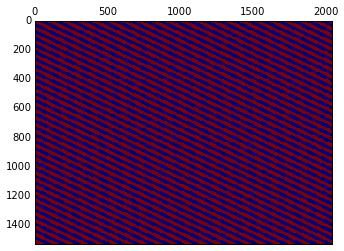

In [11]:
matshow( pattern_gen(1.492, 8, 0.5, 0, 0, 5) )

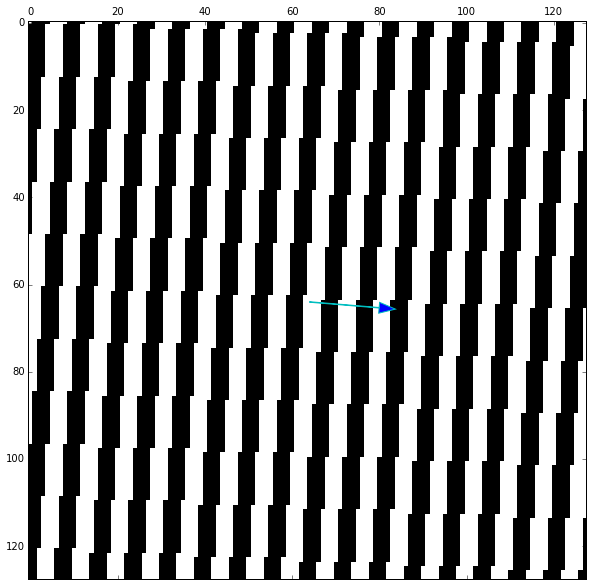

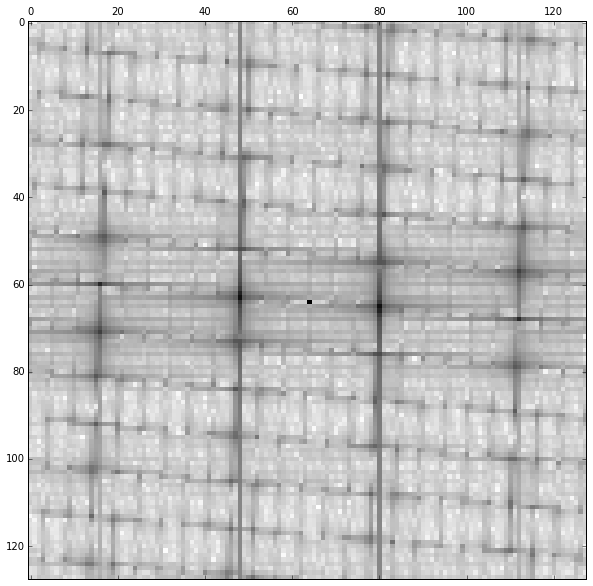

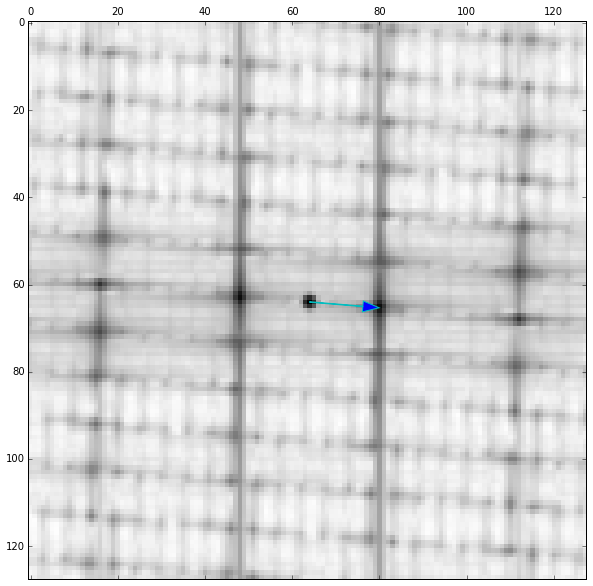

In [12]:
my_angle = deg2rad(4.76)
size=128
pat =  pattern_gen(my_angle, 8, 0.5, 0, 0, 5,size,size)
pat_fft = ifftshift(fftn(fftshift(pat)))
l = size/8
figsize(10,10)
matshow(pat,cmap='Greys')
arrow(size/2,size/2,cos(my_angle)*l, sin(my_angle)*l,width=2/2048*size,ec='c')
grid('off')
matshow(abs(pat_fft),cmap='Greys',norm=LogNorm())
grid('off')
matshow(gaussian_filter(abs(pat_fft),10/2048*size),norm=LogNorm(),cmap='Greys')
arrow(size/2,size/2,cos(my_angle)*l, sin(my_angle)*l,width=2/2048*size,ec='c',length_includes_head=True)
grid('off')

In [13]:
def angles(init_angle, num_angles):
    thetas = arange(0., num_angles)*pi/1./num_angles + init_angle
    return thetas

In [14]:
(rad2deg(angles(deg2rad(4.76),3)))

array([   4.76,   64.76,  124.76])

In [15]:
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

In [16]:
def pattern_params(angle, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = pattern_gen(angle, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    dc_loc = ((np.array(my_pat_fft.shape)+1)//2)
    
    #make mask
    mask = ones_like(my_pat_fft)
    mask[circle(*dc_loc,radius=10)]=0
    mask[:dc_loc[0]]=0
    
    #mask data and find next biggest peak
    masked_fft_data = abs(mask*my_pat_fft)
    max_loc = unravel_index(masked_fft_data.argmax(),masked_fft_data.shape)
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)//2
    end = region_size+start

    my_pat_fft_suby = masked_fft_data[max_loc[0]+start:max_loc[0]+end,max_loc[1]]
    my_pat_fft_subx = masked_fft_data[max_loc[0],max_loc[1]+start:max_loc[1]+end]

    x = arange(start,end)
    
    xfit = polyfit(x, my_pat_fft_subx,2)
    yfit = polyfit(x, my_pat_fft_suby,2)

    x0 = -xfit[1]/(2*xfit[0])
    y0 = -yfit[1]/(2*yfit[0])

    precisepeak = array(max_loc)+array([x0,y0])-array(dc_loc)

    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    if angle < 0:
        preciseangle -= pi
    
    precise_period = n/norm(precisepeak)
    
    return {"period" : precise_period, "angle" : preciseangle, "pat" : my_pat, "pat fft" : my_pat_fft}

In [17]:
a =rand(1)*pi-pi/2
print(a)
print(tan(a))
z = pattern_params(a, 7)
print(z['angle'])

[ 0.30029348]
[ 0.30965784]
0.303874659387


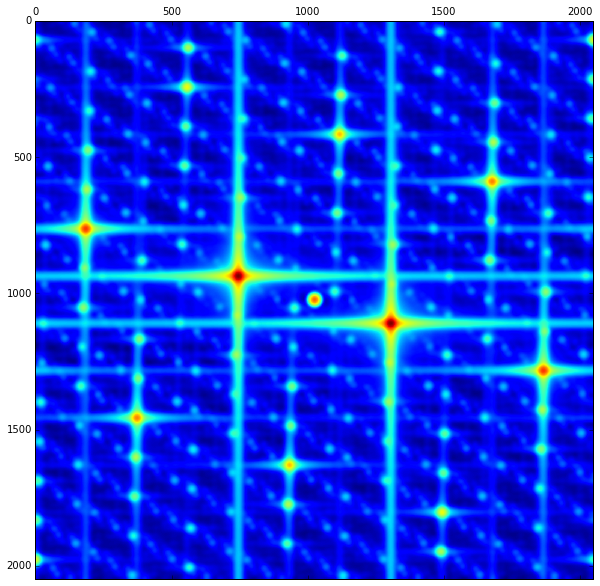

In [18]:
matshow(gaussian_filter(z['pat fft'],10),norm=LogNorm())

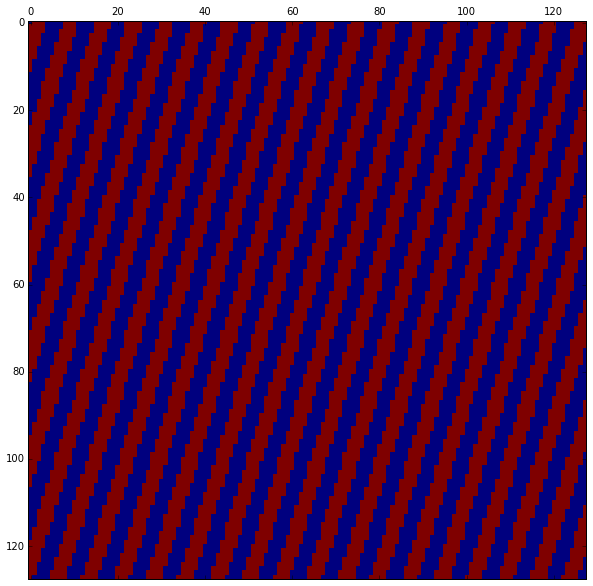

In [19]:
matshow(z['pat'][:128,:128])

In [20]:
#testing different solvers, note that Nelder-Mead and Powell methods are the
#only ones that seem to work for this function.
def objf_l1(period, iperiod, size = 1024):
    angle = 1.492
    data = array([pattern_params(angle, period,phaseInd = n,sizex = size)['period'] for n in range(1)])
    return mean(abs(data-iperiod))

def objf_l2(*args):
    return objf_l1(*args)**2

%timeit minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

%timeit minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l1_nm = minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l1_p = minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l2_nm = minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l2_p = minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

1 loops, best of 3: 1.24 s per loop
1 loops, best of 3: 2.36 s per loop
1 loops, best of 3: 1.25 s per loop
1 loops, best of 3: 3.96 s per loop


In [21]:
print('x values')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['x'][0],res_l1_p['x']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['x'][0],res_l2_p['x']))
print('Func Calls')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['nfev'],res_l1_p['nfev']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['nfev'],res_l2_p['nfev']))
print('Differences')
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']-res_l1_p['fun']))
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']**2-res_l1_p['fun']**2))
print('L2-norm: Nelder-Mead - Powell = {}'.format(res_l2_nm['fun']-res_l2_p['fun']))

x values
L1-norm: Nelder-Mead = 8.436606445312503	Powell = 8.436552077585471
L2-norm: Nelder-Mead = 8.436606445312503	Powell = 8.43654578876646
Func Calls
L1-norm: Nelder-Mead = 38	Powell = 71
L2-norm: Nelder-Mead = 38	Powell = 114
Differences
L1-norm: Nelder-Mead - Powell = 3.662237410395619e-05
L1-norm: Nelder-Mead - Powell = 4.040938787977771e-06
L2-norm: Nelder-Mead - Powell = 4.345110138979317e-06


It looks like the simplex (`'Nelder-Mead'`) algorithm is the best for this problem. Barring more complex convex methods.

In [299]:
iperiod = ideal_period(568,0.7)

def objf(period, iperiod, size = 1024):
    return objf_l1(period, iperiod, size)/iperiod*100

x = linspace(iperiod-0.05,iperiod+0.05,101)
y512 = array([objf(period, iperiod,512) for period in x])
y1024 = array([objf(period, iperiod,1024) for period in x])
y2048 = array([objf(period, iperiod,2048) for period in x])

In [300]:
res_512 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_1024 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),1024))
res_2048 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),2048))

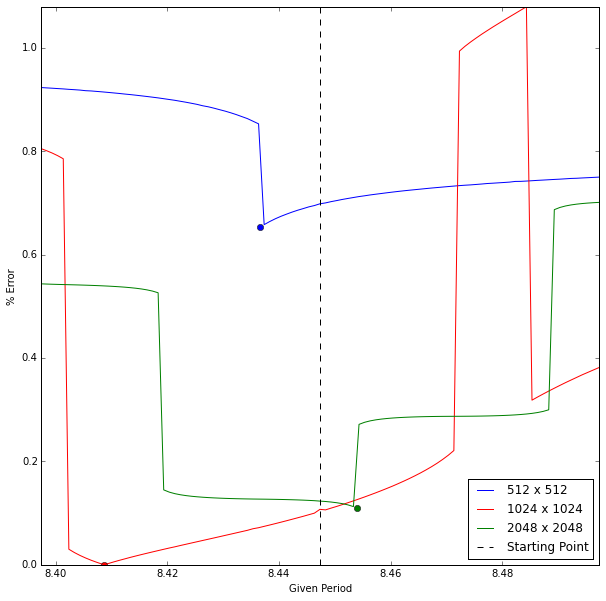

In [301]:
plot(x,y512,'b',label='512 x 512')
plot(res_512['x'],res_512['fun'],'bo')#,label='512 Optimized point')
plot(x,y1024,'r',label='1024 x 1024')
plot(res_1024['x'],res_1024['fun'],'ro')#,label='1024 Optimized point')
plot(x,y2048,'g',label='2048 x 2048')
plot(res_2048['x'],res_2048['fun'],'go')#,label='1024 Optimized point')
axis('tight')
axvline(iperiod,color='k',linestyle='dashed',label='Starting Point')
xlabel('Given Period')
ylabel('% Error')
legend(loc='best')
savefig("PeriodOpt2.pdf")

In [22]:
def opt_period(iperiod,angle,**kwargs):
    def objf_l1(period):
        data = array([pattern_params(angle, period, **kwargs)['period'] for n in range(1)])
        return mean(abs(data-iperiod))
    
    return minimize(objf_l1, iperiod ,method='Nelder-Mead')['x']

In [23]:
def opt_angle(period,iangle,**kwargs):
    def objf_l1(angle):
        data = array([pattern_params(angle, period, **kwargs)['angle'] for n in range(1)])
        return mean(abs(data-iangle))
    
    return minimize(objf_l1, iperiod ,method='Nelder-Mead')['x']

In [31]:
def objf_l1(angle, iangle, size = 1024):
    period = ideal_period(568,0.7)
    data = array([pattern_params(angle, period,phaseInd = n,sizex = size)['angle'] for n in range(1)])
    return mean(abs(data-iangle))

def objf(angle, iangle, size = 1024):
    return objf_l1(angle, iangle, size)/iangle*100

iangle = deg2rad(124.76)

x = linspace(iangle-0.05,iangle+0.05,101)
y512 = array([objf(angle, iangle,512) for angle in x])
y1024 = array([objf(angle, iangle,1024) for angle in x])
y2048 = array([objf(angle, iangle,2048) for angle in x])

In [32]:
res_512 = minimize(objf, iangle ,method='Nelder-Mead',args=(iangle,512))
res_1024 = minimize(objf, iangle ,method='Nelder-Mead',args=(iangle,1024))
res_2048 = minimize(objf, iangle ,method='Nelder-Mead',args=(iangle,2048))

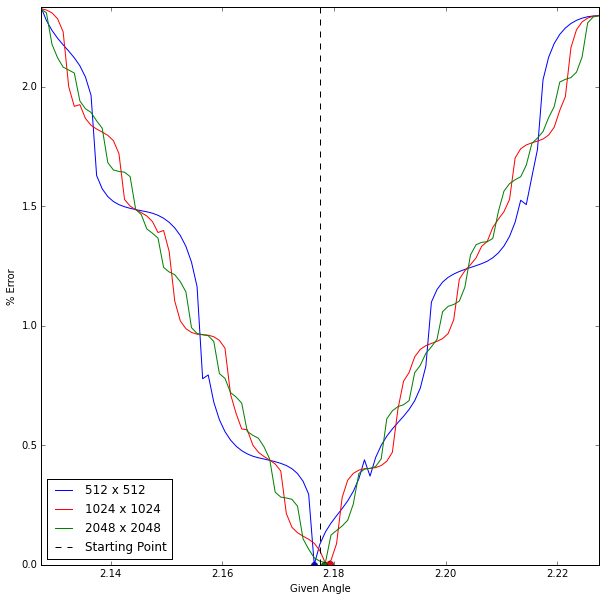

In [33]:
plot(x,y512,'b',label='512 x 512')
plot(res_512['x'],res_512['fun'],'bo')#,label='512 Optimized point')
plot(x,y1024,'r',label='1024 x 1024')
plot(res_1024['x'],res_1024['fun'],'ro')#,label='1024 Optimized point')
plot(x,y2048,'g',label='2048 x 2048')
plot(res_2048['x'],res_2048['fun'],'go')#,label='1024 Optimized point')
axis('tight')
axvline(iangle,color='k',linestyle='dashed',label='Starting Point')
xlabel('Given Angle')
ylabel('% Error')
legend(loc='best')
savefig("AngleOpt +124.76.pdf")

In [311]:
'''
We can use sets as a way to keep track of images and sequences.

Images and sequences will be denoted by strings referring to the actual file name

A repetoire will only contain a list of RunningOrders and have a method to write out running orders.

It should also have the ability to read in a .rep file

Need a method to return a given running order, by name
'''

class RunningOrder(object):
    '''
    A class representing a running order for a 4DD SLM
    '''
    
    def __init__(self, name, triggered = True):
        self._name = name
        #we want these properties to be immutable and we don't want duplicates
        self._sequences = set()
        self._bitplanes = set()
        self.triggered = triggered
        self._RO = []
        
    @property
    def name(self):
        return self._name
    
    @property
    def sequences(self):
        return self._sequences
    
    @property
    def bitplanes(self):
        return self._bitplanes
    
    @property
    def RO(self):
        return self._RO
    
    def addbitplane(self, sequence, bitplane, position = None):
        '''
        A function to add sequence bitplane pairs to a running order
        '''
        self._sequences.add(sequence)
        self._bitplanes.add(bitplane)
            
        seq_bp = {'sequence' : sequence, 'bitplane' : bitplane}
        
        if position is None:
            self._RO.append(seq_bp)
        else:
            self._RO.insert(position, seq_bp)

class Repetoire(object):
    '''
    This object holds a list of Running orders. It has the ability to output .rep files
    
    Further functionality will be to read in .rep files.
    '''
    
    def __init__(self, listofROs = None):
        self._ROs = []
        self._sequences = set()
        self._bitplanes = set()
        if listofROs is not None:
            for RO in listofROs:
                self.add_RO(RO)
        
    def add_RO(self, RO):
        
        if isinstance(RO, list):
            self.add_RO(RO.pop())
        
        if not isinstance(RO, RunningOrder):
            raise TypeError('Not a RunningOrder')
        else:
            self._ROs.append(RO)
            self._sequences |= RO.sequences
            self._bitplanes |= RO.bitplanes

    def __str__(self):
        '''
        This function writes the repetoire
        '''
        
        toreturn = ''
        
        #If ROs is empty
        if not len(self._ROs):
            return toreturn
        
        ####################
        # MAKING SEQUENCES #
        ####################
        
        #need to save the letter assignments
        seq_dict = {}
        
        seqs = ['SEQUENCES']
        for i, seq in enumerate(sorted(self._sequences)):
            char = chr(65+i)
            seqs.append(char+' "'+seq+'"')
            seq_dict[seq] = char
        
        seqs.append('SEQUENCES_END\n\n')
        
        toreturn = "\n".join(seqs)
        
        ####################
        # MAKING BITPLANES #
        ####################
        
        bp_dict = {}
        bps = ['IMAGES']
        for i, bp in enumerate(sorted(self._bitplanes)):
            bps.append('1 "'+bp+'"')
            bp_dict[bp] = i
        
        bps.append('IMAGES_END\n\n')
        
        toreturn += "\n".join(bps)
        
        #Need to have at least one RunningOrder be Default, why not the first one?
        #If no DEFAULT then MetroCon will continue to look for one and fail.
        toreturn += 'DEFAULT '
        #sort the RunningOrders by name
        for RO in self._ROs:#.sort(key=lambda x: x.name):
            toreturn += self._writeRO(RO, seq_dict, bp_dict)
            
        return toreturn
        
    @staticmethod
    def _writeRO(RO, seq_dict, bp_dict):
        '''
        This function will write the repetoire based on the sequence dict and image dict
        
        It assumes that all that is wanted is standard SIM sequences
        '''
        
        toreturn = ['"{}"'.format(RO.name)]
        
        toreturn.append('[HWA\n')
        
        if not RO.triggered:
            toappend = ' {'
        
        for seq_bp in RO.RO:
            seq = seq_bp['sequence']
            bp = seq_bp['bitplane']
            if RO.triggered:
                toreturn.append(' <t({0},{1}) >\n {{f ({0},{1}) }}'.format(seq_dict[seq],bp_dict[bp]))
            else:
                toappend += '({0},{1}) '.format(seq_dict[seq],bp_dict[bp])
        
        if not RO.triggered:
            toappend += '}'
            toreturn.append(toappend)
            
        toreturn.append(']\n\n')
        
        return '\n'.join(toreturn)
        

In [312]:
from matplotlib.patches import Circle, Wedge, Polygon

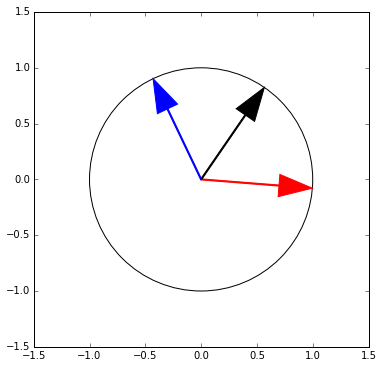

In [344]:
fig,ax = subplots(1,1,squeeze=True, figsize=(6,6))
circle = Circle((0,0),1,fill=False)
ax.add_patch(circle)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
colors = ('r','k','b')
for ang, c in zip(angles(1.492,3),colors):
    ax.arrow(0,0,cos(ang-pi/2),sin(ang-pi/2),length_includes_head=True,width=.01,ec=c,fc=c)

In [360]:
##Regular SIM for 488 and 561
onfrac = 0.5
my_angles = angles(deg2rad(4.76),3)
    
num_phases = 3

name = 'SIM 2D 488 and 561 New Algo test'

#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('{}.repz11'.format(name), 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = False

    my_dir = os.path.join(name,'')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NAs = linspace(0.78,0.85,8)
    
    ROlist = []
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for wl in [488, 561]:
        for NA in NAs:
            print('{} NA {}'.format(wl, NA))

            iperiod = ideal_period(wl,NA=NA)
            super_RO = RunningOrder('{} SIM NA {}'.format(wl,NA))

            RO_all_t = RunningOrder('{} NA {} All Orientations Triggered'.format(wl,NA))
            RO_all = RunningOrder('{} NA {} All Orientations'.format(wl,NA),triggered=False)

            patall =zeros((1536, 2048))

            for angle in my_angles:

                #calculate degree from angle for filename
                degree = rad2deg(angle)

                RO1orient = RunningOrder('{} NA {} {:+.2f} degrees'.format(wl, NA, degree), triggered=False)

                #optimize the angle
                if opt:
                    print('Optimizing angle = {:+.2f} degrees'.format(degree))
                    my_per = opt_period(iperiod,angle)[0]
                else:
                    my_per = iperiod

                for phase in range(num_phases):
                    #generate pattern
                    pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases)

                    #make image object
                    pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')

                    #generate filename, put orientation in front, so that its consistent
                    name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per,onfrac)

                    #convert to binary and save
                    pat_img.convert('1').save(os.path.join(my_dir,name))

                    #move to zip file and save
                    myzip.write(os.path.join(my_dir,name),arcname=name)

                    super_RO.addbitplane(seq,name)

                    if not phase:
                        RO1orient.addbitplane(seq,name)
                        #add to all angles pattern
                        patall += pat

                    print('Wrote file: {}'.format(name))

                ROlist.append(RO1orient)

            #make image object for all
            patall_img = Image.fromarray((patall/num_angles*255).astype('uint8'),mode='L')

            #generate filename, put orientation in front, so that its consistent
            nameall = 'pat-{:.2f}NA-{:.4f}pix-{:.2f}DC_allangles.bmp'.format(NA,my_per,onfrac)

            #convert to binary and save
            patall_img.convert('1').save(os.path.join(my_dir,nameall))

            #move to zip file and save
            myzip.write(os.path.join(my_dir,nameall),arcname=nameall)

            RO_all_t.addbitplane(seq,nameall)
            RO_all.addbitplane(seq,nameall)

            ROlist.append(super_RO)
            ROlist.append(RO_all_t)
            ROlist.append(RO_all)

    my_Rep = Repetoire(ROlist)

    #write the rep file
    with open(os.path.join(my_dir,'{}.rep'.format(name)),'w') as repfile:
        repfile.write(str(my_Rep))

    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'{}.rep'.format(name)),arcname='{}.rep'.format(name))
    
print(my_Rep)

488 NA 0.78
Wrote file: pat-0.78NA+4.8deg-00ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-01ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-02ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+64.8deg-00ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+64.8deg-01ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+64.8deg-02ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+124.8deg-00ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+124.8deg-01ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+124.8deg-02ph-6.4970pix-0.50DC.bmp
488 NA 0.79
Wrote file: pat-0.79NA+4.8deg-00ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+4.8deg-01ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+4.8deg-02ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+64.8deg-00ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+64.8deg-01ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+64.8deg-02ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+124.8deg-00ph-6.4130pix-0.50DC.bmp
Wrote file: pat-0.79NA+124.8deg-01ph-6.4130pix-0.50DC.bmp
Wrote fi

In [363]:
#Super SIM
onfrac = 0.5
num_angles = 3
my_angles = angles(deg2rad(4.76),num_angles)
    
num_phases = 24

wl = 488

name = 'SIM{}_2D_newalgo'.format(wl)
#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('{}.repz11'.format(name), 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = False

    my_dir = os.path.join('{}'.format(name),'')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NAs = linspace(0.78,0.85,8)
    
    ROlist = []
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for NA in NAs:
        print('NA {}'.format(NA))
        
        iperiod = ideal_period(wl,NA=NA)
        super_RO = RunningOrder('Super SIM NA {}'.format(NA))
        reg_RO = RunningOrder('SIM NA {}'.format(NA))
        
        RO_all_t = RunningOrder('NA {} All Orientations Triggered'.format(NA))
        RO_all = RunningOrder('NA {} All Orientations'.format(NA),triggered=False)
        
        patall =zeros((1536, 2048))
        
        for angle in my_angles:
            
            #calculate degree from angle for filename
            degree = rad2deg(angle)
            
            RO1orient = RunningOrder('NA {} {:+.2f} degrees'.format(NA, degree), triggered=False)
            
            #optimize the angle
            if opt:
                print('Optimizing angle = {:+.2f} degrees'.format(degree))
                my_per = opt_period(iperiod,angle)[0]
            else:
                my_per = iperiod

            for phase in range(num_phases):
                #generate pattern, but with two periods
                pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases,SIM_2D=False)
                
                #make image object
                pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')
                
                #generate filename, put orientation in front, so that its consistent
                name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per,onfrac)
                
                #convert to binary and save
                pat_img.convert('1').save(os.path.join(my_dir,name))
                
                #move to zip file and save
                myzip.write(os.path.join(my_dir,name),arcname=name)
                
                super_RO.addbitplane(seq,name)
                
                if not phase:
                    RO1orient.addbitplane(seq,name)
                    #add to all angles pattern
                    patall += pat
                
                #only pull the first three phases so that we can do regular SIM too
                if (phase % (num_phases//6) == 0) and (phase/num_phases*2 < 1):
                    reg_RO.addbitplane(seq,name)
                
                print('Wrote file: {}'.format(name))
                
            ROlist.append(RO1orient)
            
        #make image object for all
        patall_img = Image.fromarray((patall/num_angles*255).astype('uint8'),mode='L')

        #generate filename, put orientation in front, so that its consistent
        nameall = 'pat-{:.2f}NA-{:.4f}pix-{:.2f}DC_allangles.bmp'.format(NA,my_per,onfrac)

        #convert to binary and save
        patall_img.convert('1').save(os.path.join(my_dir,nameall))

        #move to zip file and save
        myzip.write(os.path.join(my_dir,nameall),arcname=nameall)
        
        RO_all_t.addbitplane(seq,nameall)
        RO_all.addbitplane(seq,nameall)
        
        ROlist.append(super_RO)
        ROlist.append(reg_RO)
        ROlist.append(RO_all_t)
        ROlist.append(RO_all)
                
    my_Rep = Repetoire(ROlist)
    
    #write the rep file
    with open(os.path.join(my_dir,'{}.rep'.format(name)),'w') as repfile:
        repfile.write(str(my_Rep))
        
    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'{}.rep'.format(name)),arcname='{}.rep'.format(name))
    
print(my_Rep)

Making SIM488_2D_newalgo\
NA 0.78
Wrote file: pat-0.78NA+4.8deg-00ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-01ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-02ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-03ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-04ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-05ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-06ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-07ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-08ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-09ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-10ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-11ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-12ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-13ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-14ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-15ph-6.4970pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-16ph-6.4970pix-0.50DC.bmp
Wrote file: pa